In [1]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

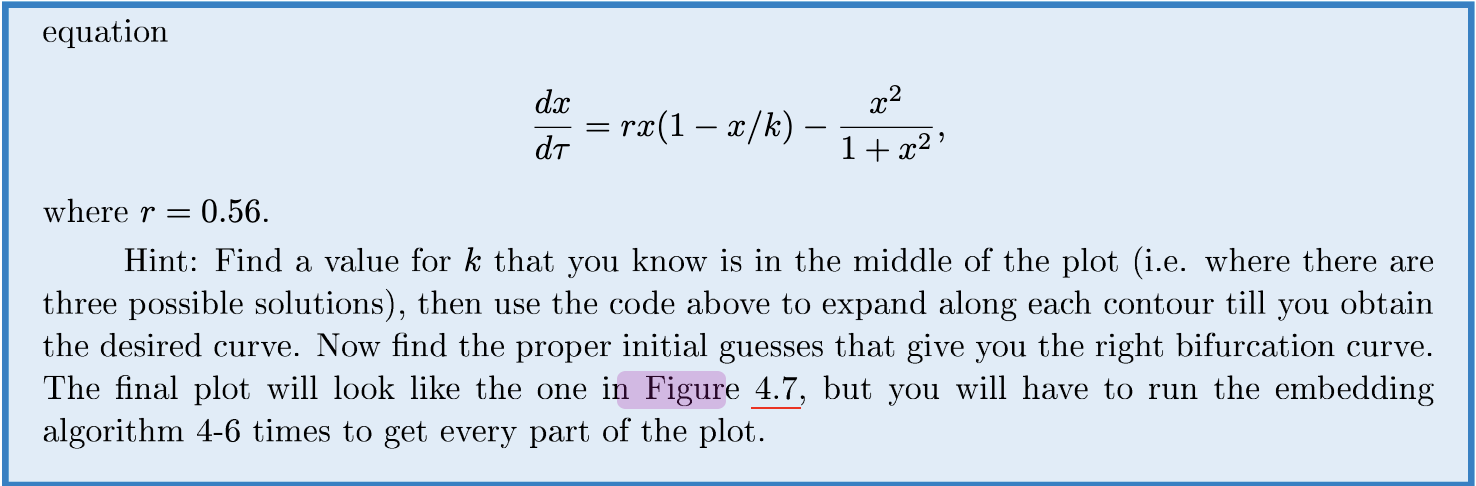

In [2]:
# note that a factor of x has been removed to avoid x=0 solution.
def simple_hysteresis_ode(t,x,r,k):
    return r*(1-x/k)- x / (1+x**2)

Descriminant of simple hysteresis ode model

$$r (1-\frac{x}{k}) - \frac{x}{1+x^2} = 0$$
$$x = r(1+x^2)(1-\frac{x}{k})$$
$$x = r(1 - \frac{x}{k} + x^2 - \frac{x^3}{k})$$
$$0 = r - \frac{r+k}{k}x + rx^2 -r\frac{x^3}{k}$$
$$\frac{r}{k}x^3 - rx^2 + \frac{k+r}{k}x - r=0$$

In [3]:
def descriminant(k,r):
    """
    ax^3 + bx^2 + cx + d = 0
    https://en.wikipedia.org/wiki/Cubic_equation
    """
    a = r/k
    b = -r
    c = (k+r)/k
    d = -r
    p = (3*a*c-b**2) / (3*a**2)
    q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

    return - (4*p**3 + 27*q**2)

In [4]:
from sympy import symbols, Eq, solve, simplify

r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
r1, r2 = solve(Eq(D_fixed, 0), k)


In [5]:
r1,r2

(6.44569072482332, 9.93441120446710)

for $k \in \text{supp}(\Delta > 0)$ the dynamical system exhibits 3 equilibria

where $\text{supp}(\Delta > 0) = [6.44569072482332,9.93441120446710]$ for $r=0.56$

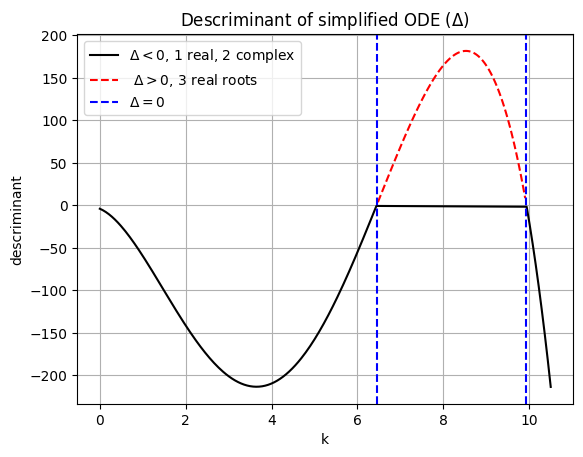

In [6]:
k = np.linspace(0+1e-15, 10.5, 301)
# k = np.linspace(-10.5,0-1e-15, 301)
des = np.array([descriminant(ki, r=0.56) for ki in k])

one_root = np.where(des<0)
three_root = np.where(des >=0)

# print(one_root)



plt.plot(k[one_root],des[one_root], c='black', label=r'$\Delta < 0$, 1 real, 2 complex')
plt.plot(k[three_root],des[three_root], linestyle='--', c='red', label=r' $\Delta > 0$, 3 real roots')
plt.axvline(r1, linestyle='--', c='blue', label=r'$\Delta=0$')
plt.axvline(r2, linestyle='--', c='blue')
plt.title(r"Descriminant of simplified ODE ($\Delta$)")
plt.xlabel("k")
plt.ylabel("descriminant")
plt.legend()
plt.grid(True)
plt.show()

# create movie

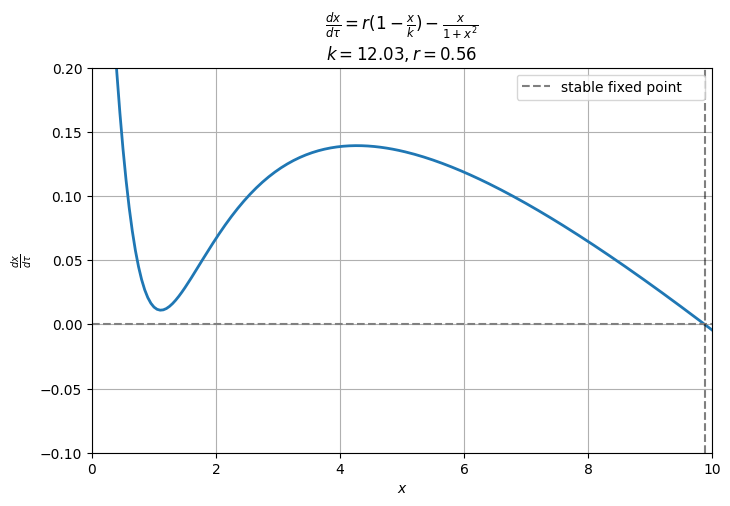

In [26]:

from matplotlib.animation import FuncAnimation, PillowWriter

r = 0.56
k_vals = np.linspace(float(r1)-1.1, float(r2)+2.1, 201) 

def poly_coeff(k,r): 
    a = r/k
    b = -r
    c = (k+r)/k
    d = -r
    return [a,b,c,d]

def real_roots(coeffs):
    roots = np.roots(coeffs)
    return sorted([r.real for r in roots if np.isreal(r)])

fig, ax = plt.subplots(figsize=(8, 5))
line, = ax.plot([], [], lw=2)

def init():
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$\frac{dx}{d\tau}$")
    return line,

def update(frame):
    k = k_vals[frame]
    coeffs = poly_coeff(k, r)
    roots = real_roots(coeffs)
    xs = np.linspace(0,10,201)
    if len(roots) < 3:
        ys = simple_hysteresis_ode(None, xs, r, k)

        ax.clear()
        ax.plot(xs, ys, lw=2)

        ax.axhline(0, color='gray', linestyle='--')

        ax.axvline(x=roots[0], color='black', linestyle='--', alpha=0.5, label="stable fixed point"+" "*4)

        ax.set_xlim(xs[0], xs[-1])
        ax.set_ylim(-0.1, 0.2)
        ax.legend(loc='upper right')

        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$\frac{dx}{d\tau}$")
        ax.set_title(r"$\frac{dx}{d\tau} = r(1 - \frac{x}{k}) - \frac{x}{1+x^2}$" + f"\n$k={k:.2f}, r={r}$")
        ax.grid(True)
        return ax.lines

    ys = simple_hysteresis_ode(None, xs, r, k)

    ax.clear()
    ax.plot(xs, ys, lw=2)

    ax.axhline(0, color='gray', linestyle='--')

    ax.axvline(x=roots[0], color='black', linestyle='--', alpha=0.5, label="stable fixed point")
    ax.axvline(x=roots[1], color='red', linestyle='--', alpha=0.5, label="unstable fixed point")
    ax.axvline(x=roots[2], color='black', linestyle='--', alpha=0.5,)

    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$\frac{dx}{d\tau}$")
    ax.set_title(r"$\frac{dx}{d\tau} = r(1 - \frac{x}{k}) - \frac{x}{1+x^2}$" + f"\n$k={k:.2f}, r={r}$")
    ax.set_xlim(xs[0], xs[-1])
    ax.set_ylim(-0.1, 0.2)

    ax.grid(True)
    ax.legend(loc='upper right')

    return ax.lines


ani = FuncAnimation(fig, update, frames=len(k_vals), init_func=init, blit=False)
ani.save("simple_hysteresis_roots.gif", writer=PillowWriter(fps=30))


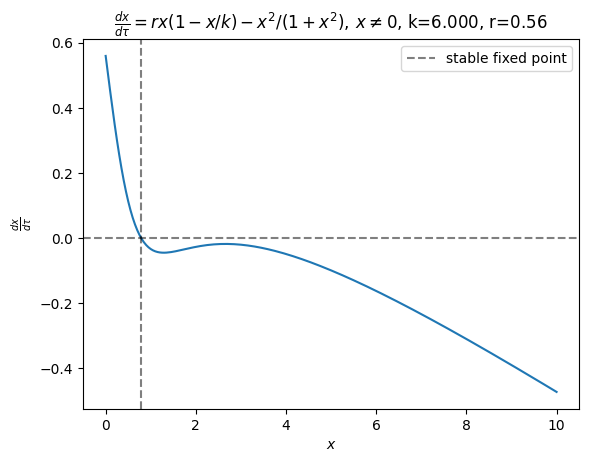

In [8]:
# for k= 8
k = 6
# k=r1
r=0.56

coeffs = poly_coeff(k, r)
roots = real_roots(coeffs)
x0 = 0
x1 = 10

xs = np.linspace(x0, x1, 201)
dt = xs[1]-xs[0]

fig, ax = plt.subplots()

ax.plot(xs,simple_hysteresis_ode(None,xs,r,k))
ax.axvline(x=roots[0], color='black', linestyle='--', alpha=0.5, label="stable fixed point")
if len(roots)==3:
    ax.axvline(x=roots[1], color='red', linestyle='--', alpha=0.5, label="unstable fixed point")
    ax.axvline(x=roots[2], color='black', linestyle='--', alpha=0.5,)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5,)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\frac{dx}{d\tau}$")

ax.set_title(r"$\frac{dx}{d \tau} = rx (1-x/k)-x^2/ (1+x^2), \: x\neq 0$, " + f"k={k:.3f}, r={r}")
ax.legend(loc='upper right')
plt.show()

# Plot steady state controlled by $k(t)$

In [18]:

def budworm_ode(t,x,r,k):
    return r*x*(1-x/k) - x**2 / (1+x**2)


def simulate_steady_state(k_vals, x0):
    t_span = [0,100]
    t_eval = [t_span[-1]]
    r=0.56
    x_vals = []
    x_curr = x0
    for k in tqdm(k_vals):
        sol = solve_ivp(budworm_ode, t_span=t_span, y0=[x_curr],args = (r,k,), t_eval=t_eval)
        x_curr = sol.y[0,-1]
        x_vals.append(x_curr)
    return np.array(x_vals)

In [19]:
x0 = 1

k_start = k_vals[0]
k_end = k_vals[-1]
n_points = 301

k_increase = np.linspace(k_start,k_end, n_points)
k_decrease = np.linspace(k_increase[-1],k_start,n_points)


In [20]:
x_increase = simulate_steady_state(k_increase,x0=x0)
x_decrease = simulate_steady_state(k_decrease, x0=x_increase[-1])

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

In [21]:
x_increase.min()

0.755164347140098

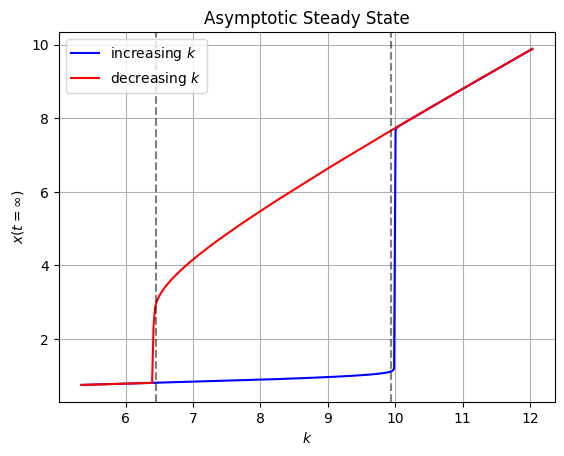

In [22]:

plt.plot(k_increase, x_increase, c='blue', label=r"increasing $k$")
plt.plot(k_decrease, x_decrease, c='red', label=r"decreasing $k$")
plt.xlabel(r"$k$")
plt.ylabel(r"$x(t=\infty)$")
plt.axvline(r1,linestyle="--", c='black', alpha=0.5)
plt.axvline(r2,linestyle="--", c='black', alpha=0.5)

plt.title("Asymptotic Steady State")
plt.grid(True)
plt.legend(loc = "upper left")
plt.show()

# Create Movie

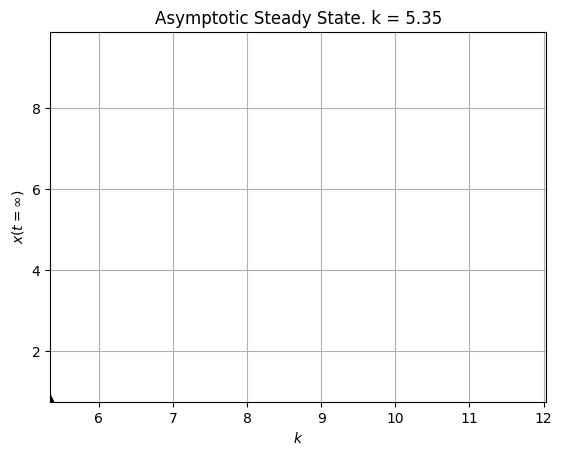

In [30]:
idx = 100
# print(len(k_increase))


fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$x(t = \infty)$")
    ax.set_xlim(k_increase[0], k_increase[-1])
    ax.set_ylim(min(x_increase.min(), x_decrease.min()), max(x_increase.max(), x_decrease.max()))
    ax.grid(True)

    if frame < len(k_increase):
        ax.plot(k_increase[:frame], x_increase[:frame], c='blue')
        ax.scatter(k_increase[frame], x_increase[frame], marker='^', s=100, c='black')
        ax.set_title(f"Asymptotic Steady State. k = {k_increase[frame]:.2f}")
    else:
        idx = frame - len(k_increase)
        ax.plot(k_increase, x_increase, c='blue')
        ax.plot(k_decrease[:idx], x_decrease[:idx], c='red')
        ax.scatter(k_decrease[idx], x_decrease[idx], marker='^', s=100, c='black')
        ax.set_title(f"Asymptotic Steady State. k = {k_decrease[idx]:.2f}")

    return ax.lines

ani = FuncAnimation(fig, update, frames=len(k_increase) + len(k_decrease), blit=False)
ani.save("steady_state_budworm.gif", writer=PillowWriter(fps=30))

